In [ ]:
### 
    # This code plot the spatial patterns of CMIP6 model ensemble mean ALT sensitivity on two timesacles.
    # (a)seasonal-cycle, and under global warming levels of (b)1.5°C, (c)2°C and (d)3°C relative to pre-industrial period (1850-1900) under SSP5-8.5 scenario. 
    # 1. The ALT sensitivity is read from "../Data/ALT_Sensitivity_lat_lon/", which is derived from "../Process/06*.py".
    # 2. For each time scale, calculate the mean sensitivity of all models at each grid point.
    # 3. Plot spatial distribution.
    # 4. Calculate the spatial correlation coefficient.
    # 5. Output: Figure S6.
###

In [4]:
import numpy as np
from scipy import stats
import xarray as xr
import string
import glob
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings("ignore")

# Matplotlib and Proplot 
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import proplot as pplt
# Cartopy 
import cartopy.crs as ccrs

In [5]:
lat = np.linspace(45.25, 89.75, 90)
lon = np.linspace(0.25, 359.75, 720)
# Create mask_landsea
lon_grid, lat_grid = np.meshgrid(lon, lat)
shapefile_path = '/home/wangjx/Data/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)
mask_landsea = np.zeros_like(lon_grid, dtype=bool)

for i in range(len(lat)):
    for j in range(len(lon)):
        lon_point = lon_grid[i, j]
        lat_point = lat_grid[i, j]

        # Determine whether the grid point is on land
        point = Point(lon_point, lat_point)
        is_on_land = False
        for geometry in gdf.geometry:
            if geometry.intersects(point):
                is_on_land = True
                break

        mask_landsea[i, j] = is_on_land

r 0.6598852935
p-value: 0.0000000000e+00
r 0.6814127567
p-value: 0.0000000000e+00
r 0.6578613048
p-value: 0.0000000000e+00


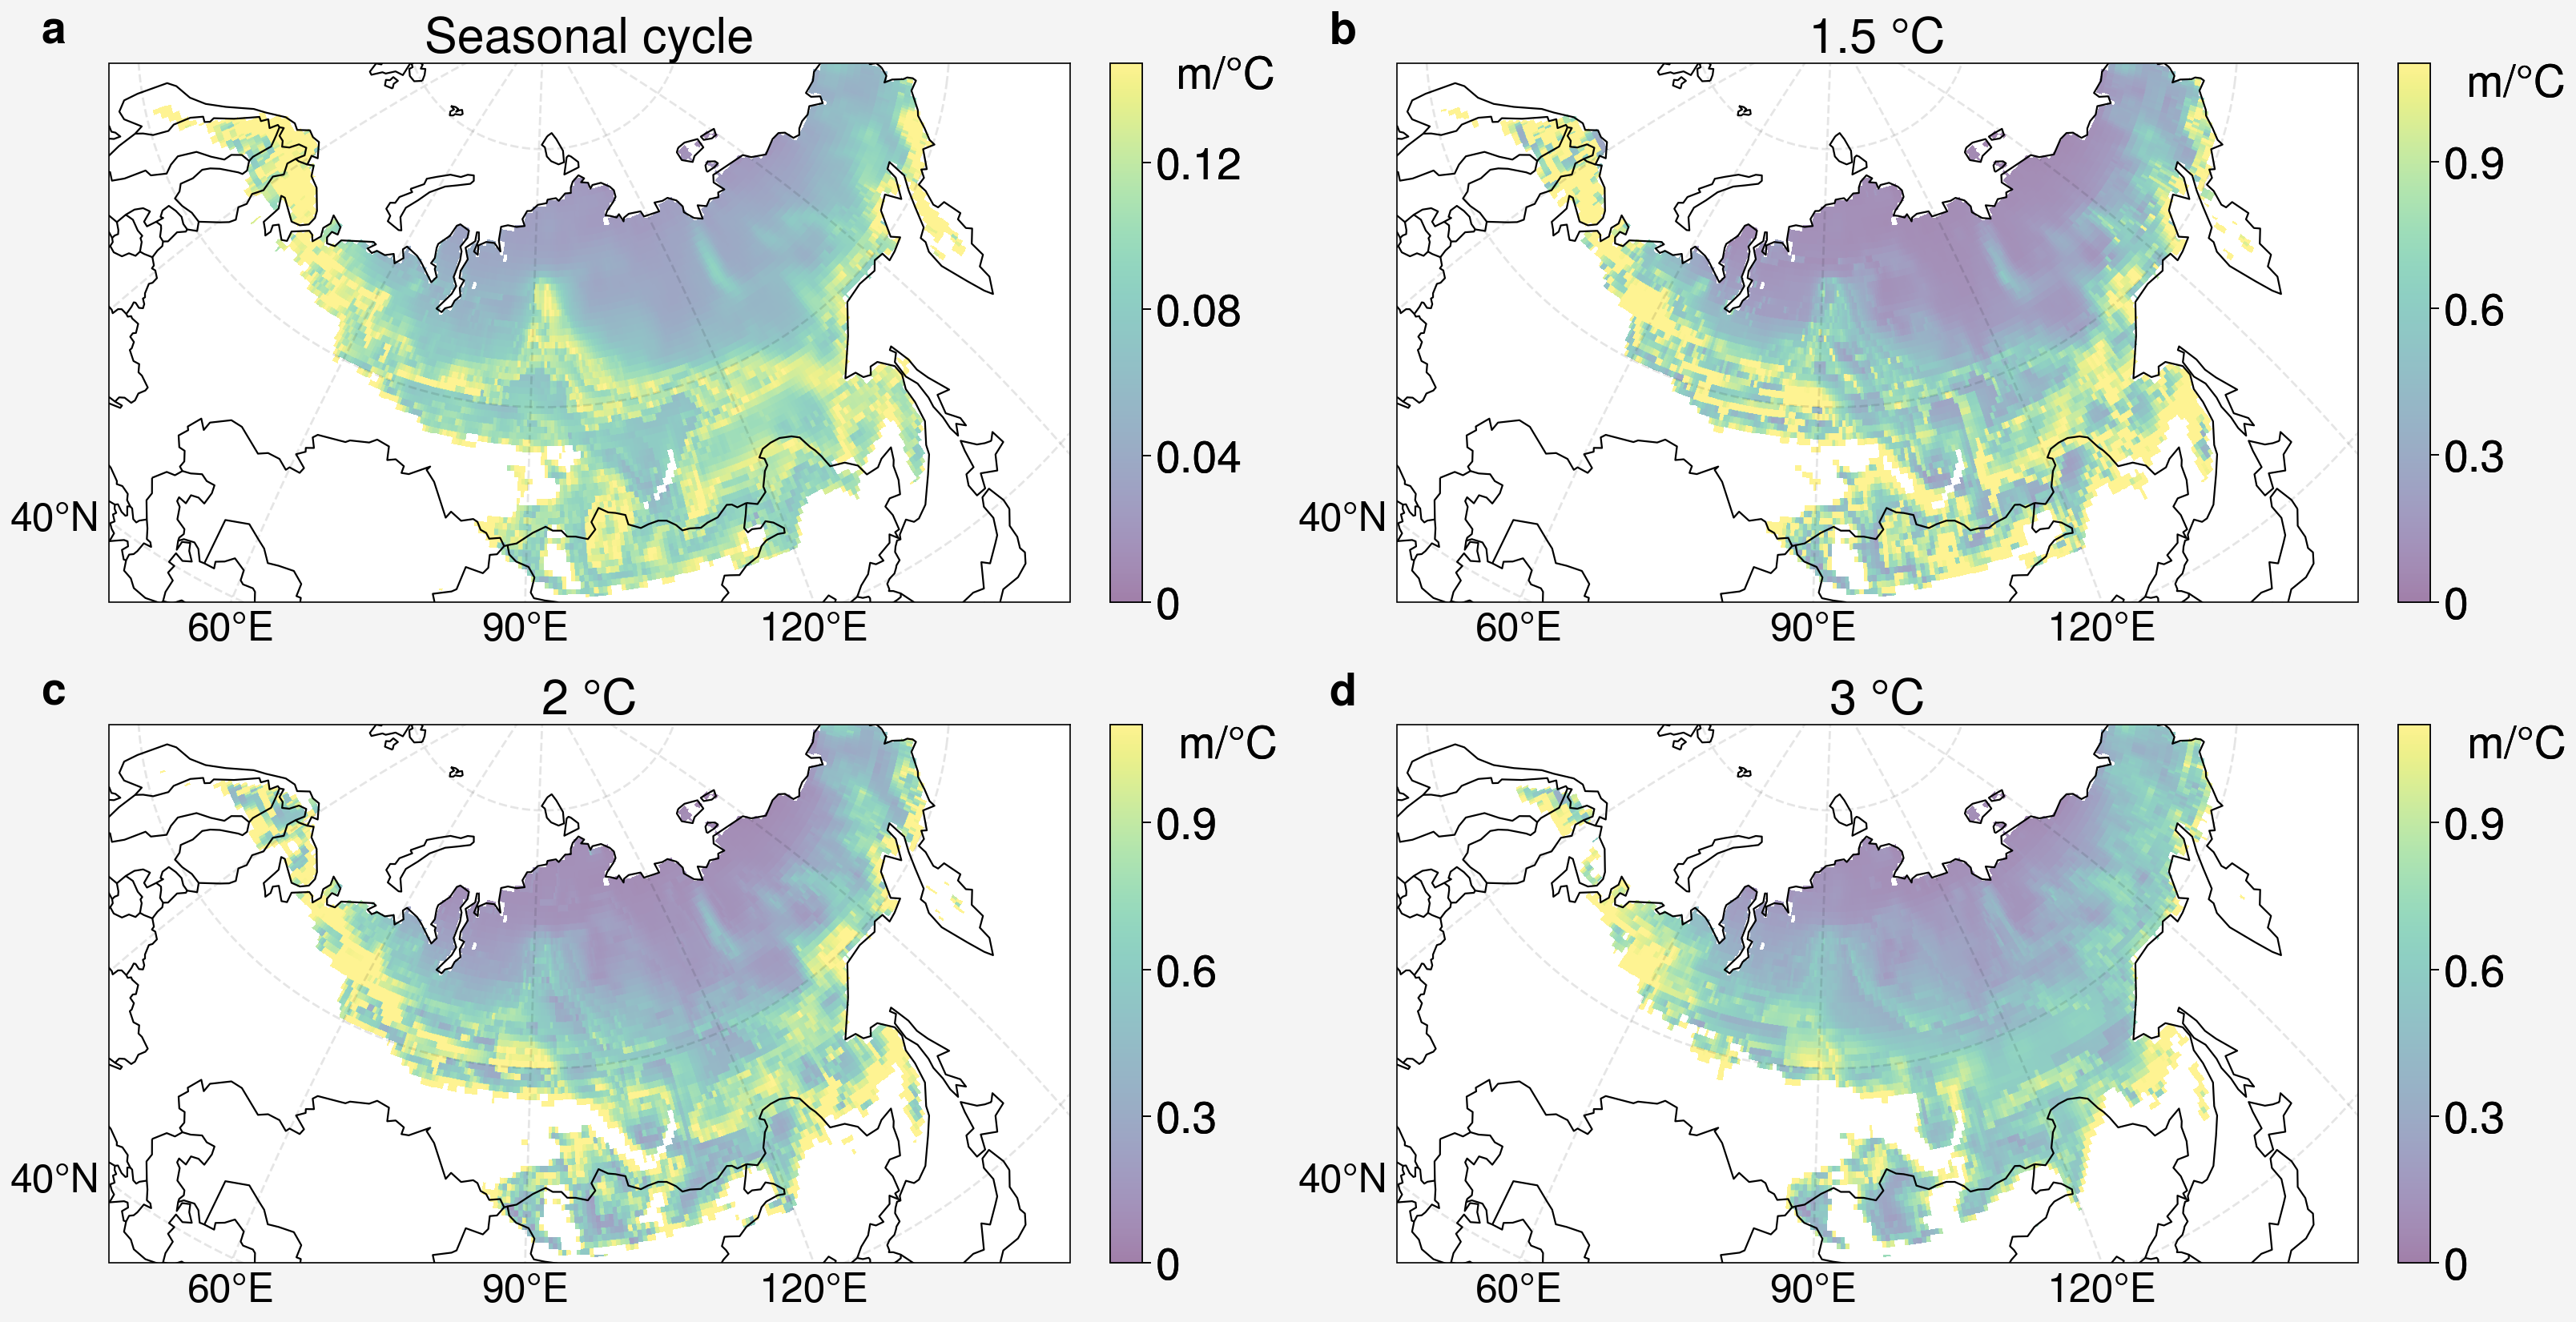

In [6]:
degree = [1.5,2,3]
model = ["CESM2","CESM2-FV2","CESM2-WACCM","CNRM-CM6-1-HR","CNRM-CM6-1","CNRM-ESM2-1",
         "E3SM-1-1","FGOALS-f3-L","FGOALS-g3","GFDL-CM4","GFDL-ESM4","MIROC6","MIROC-ES2L",
         "MPI-ESM1-2-HR","MPI-ESM1-2-LR","NorESM2-LM","NorESM2-MM","TaiESM1"]

fig, axs = pplt.subplots(nrows=2, ncols=2, refwidth=6, span=False, proj='laea', proj_kw={'lon_0': 92, 'lat_0': 55})
pplt.rc.reso = 'lo'
proj = pplt.Proj('laea')
shapefile_path = '/home/wangjx/Data/ne_110m_admin_0_boundary_lines_land/ne_110m_admin_0_boundary_lines_land.shp'
gdf = gpd.read_file(shapefile_path)
letters = list(string.ascii_lowercase)  # For labeling
for ax in axs:
    ax.format(
        gridlabelsize=18,
        labels=True, lonlines=30, latlines=20,
        coast=True, gridminor=False, coastlinewidth=0.8,
        gridlinestyle='--',  # Set meridian and parallel gridlines to dashed style
        gridlinewidth=1.     # Set the linewidth of meridian and parallel gridlines
    )
    ax.set_extent([40, 160, 45, 82], crs=ccrs.PlateCarree())

    for geometry in gdf.geometry:
        ax.add_geometries([geometry], facecolor='none', edgecolor='black', linewidth=0.8, crs=ccrs.PlateCarree())

for i in range(len(degree)):

    # Initialize lists to store model data
    alt_seasonalcycle_list = []
    alt_climatechange_list = []

    # Iterate through each model's data
    for modelname in model:
        
        # Read seasonal-scale data file
        alt_file = '../Data/ALT_Sensitivity_lat_lon/seasonal_scale/' + modelname + '_alt_seasonalcycle_avg.nc'
        f = xr.open_dataset(alt_file)
        
        # Climate-change scale
        alt_file2 = glob.glob('../Data/ALT_Sensitivity_lat_lon/'+str(degree[i])+'degree/' + modelname + '_alt_climatechange_avg.nc')[0]
        g = xr.open_dataset(alt_file2)
        alt_seasonalcycle = f['alt_seasonalcycle_avg'][:,:]
        alt_climatechange = g['alt_tsl'][:,:]
       
        # Append each model's data to the list
        alt_seasonalcycle_list.append(alt_seasonalcycle)
        alt_climatechange_list.append(alt_climatechange)

    # Calculate ensemble mean
    alt_seasonalcycle_mean = np.nanmean(alt_seasonalcycle_list, axis=0)
    alt_climatechange_mean = np.nanmean(alt_climatechange_list, axis=0)
    
    # Mask ocean
    alt_seasonalcycle_mean = np.where(~mask_landsea[:,:360], np.nan, alt_seasonalcycle_mean)
    alt_climatechange_mean = np.where(~mask_landsea[:,:360], np.nan, alt_climatechange_mean)
    
    # Count the number of valid (non-NaN) values
    valid_counts_1 = np.sum(~np.isnan(alt_seasonalcycle_list), axis=0)
    valid_counts_2 = np.sum(~np.isnan(alt_climatechange_list), axis=0)

    # Create a mask array to indicate valid positions
    mask = np.logical_and(~np.isnan(alt_seasonalcycle_mean), ~np.isnan(alt_climatechange_mean))

    # Step 1: Normalize the means
    norm_tsl1 = (alt_seasonalcycle_mean - np.nanmean(alt_seasonalcycle_mean)) / np.nanstd(alt_seasonalcycle_mean)
    norm_tsl2 = (alt_climatechange_mean - np.nanmean(alt_climatechange_mean)) / np.nanstd(alt_climatechange_mean)

    # Flatten the DataArray objects into 1D arrays
    norm_tsl1_flat = norm_tsl1.ravel()
    norm_tsl2_flat = norm_tsl2.ravel()
    mask_flat = mask.ravel()

    # Calculate Pearson correlation coefficient for valid values
    pearson_corr = np.sum(norm_tsl1_flat[mask_flat] * norm_tsl2_flat[mask_flat]) / np.sqrt(np.sum(norm_tsl1_flat[mask_flat] ** 2) * np.sum(norm_tsl2_flat[mask_flat] ** 2))
    print('r', round(pearson_corr, 10))
    n = np.sum(mask_flat)  # Number of valid samples
    df = n - 2

    # Calculate t-value
    t_stat = pearson_corr * np.sqrt(df / (1 - pearson_corr**2))

    # Calculate p-value (two-sided)
    p_value = 2 * stats.t.sf(np.abs(t_stat), df)
    print(f'p-value: {p_value:.10e}')

    if i == 0:
        # Plot the sensitivity on seasonal scale
        imshow1 = axs[0].imshow(alt_seasonalcycle_mean, extent=(0, 180, 45, 90), origin='lower', 
                                cmap='viridis', alpha=0.5, transform=ccrs.PlateCarree(), 
                                vmin=0.0, vmax=0.147)
        axs[0].text(
            -0.07, 1.02,
            f"{letters[i]}",
            transform=axs[0].transAxes,
            fontproperties=FontProperties(weight='bold', size=20),
            verticalalignment='bottom',
            color='black')
        axs[0].set_title('Seasonal cycle', fontsize=22)
        
        # Add colorbar
        cbar1 = fig.colorbar(imshow1, ax=axs[0], ticks=np.arange(0, 0.147, 0.04),pad=2)
        cbar1.ax.tick_params(labelsize=20)
        cbar1.ax.text(
            1.11, 0.975, 'm/°C',
            fontsize=20, 
            transform=axs[0].transAxes,
            rotation=0,
            verticalalignment='center')
        
        # Plot 1.5°C
        imshow2 = axs[i+1].imshow(alt_climatechange_mean, extent=(0, 180, 45, 90), origin='lower', 
                                cmap='viridis', alpha=0.5, transform=ccrs.PlateCarree(),
                                vmin=0.0, vmax=1.1)
        axs[i+1].text(
            -0.07, 1.02,
            f"{letters[i+1]}",
            transform=axs[i+1].transAxes,
            fontproperties=FontProperties(weight='bold', size=20),
            verticalalignment='bottom', 
            color='black')
        axs[i+1].set_title(str(degree[i])+' °C', fontsize=22)

        # Add colorbar
        cbar2 = fig.colorbar(imshow2, ax=axs[i+1], ticks=np.arange(0, 1.1, 0.3),pad=2)
        cbar2.ax.tick_params(labelsize=20)  # Adjust font size of colorbar ticks
        cbar2.set_label('m/°C', fontsize=20,labelpad=4.8, rotation=0)
        cbar2.ax.yaxis.label.set_position((1.03, 1.)) 
        
    else:   # Plot 2°C and 3°C
        imshow2 = axs[i+1].imshow(alt_climatechange_mean, extent=(0, 180, 45, 90), origin='lower', 
                                cmap='viridis', alpha=0.5, transform=ccrs.PlateCarree(), 
                                vmin=0.0, vmax=1.1)
        # Add labels
        axs[i+1].text(
            -0.07, 1.02,
            f"{letters[i+1]}",
            transform=axs[i+1].transAxes,
            fontproperties=FontProperties(weight='bold', size=20),
            verticalalignment='bottom',
            color='black')
        axs[i+1].set_title(str(degree[i])+' °C', fontsize=22,loc='center')

        # Add colorbar
        cbar2 = fig.colorbar(imshow2, ax=axs[i+1], ticks=np.arange(0, 1.1, 0.3),pad=2)
        cbar2.ax.tick_params(labelsize=20)
        cbar2.set_label('m/°C', fontsize=20,labelpad=5, rotation=0)
        cbar2.ax.yaxis.label.set_position((1.05, 1.))

plt.show()

In [ ]:
fig.savefig("../Figures/FigureS6.png", bbox_inches='tight',dpi=300)